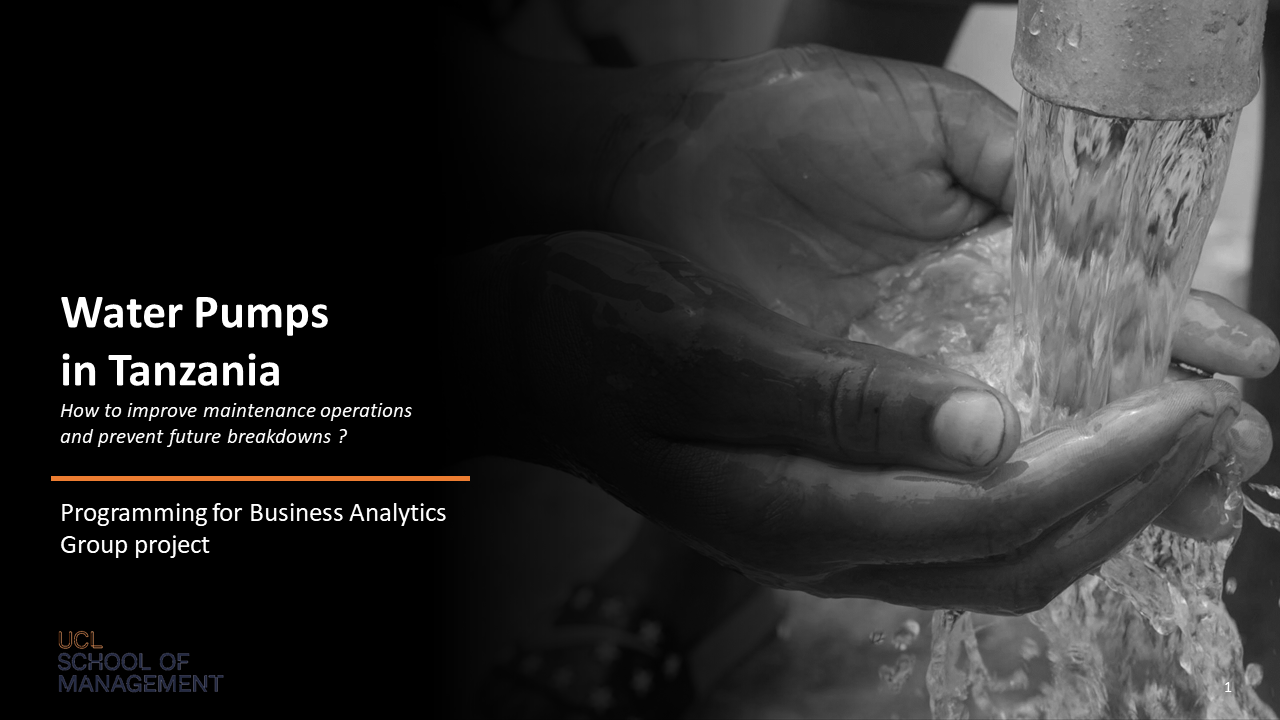

In [1]:
import io
from nbformat import current
def nb_word_count(nb_path):
    with io.open(nb_path, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')
        word_count = 0
        for cell in nb.worksheets[0].cells:
            if cell.cell_type == "markdown":
                word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    return word_count

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/nbformat/current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


In [2]:
nb_word_count('/project/J2_Group_Assignment_MSIN0143.ipynb')

2081

In [3]:
import os 
os.getcwd()

'/project'

# Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Set-up](#2.-Set-up)
* [3. Data cleaning](#3.-Data-cleaning)
    * [3.1 Overview of the raw dataset](#3.1-Overview-of-the-raw-dataset)
    * [3.2 Missing information](#3.2-Missing-information)
    * [3.3 Creating cleaned csv](#3.3-Creating-cleaned-csv)
* [4. Analysis](#4.-Analysis)
    * [4.1 Economics factors](#4.1-What-is-Python?)
    * [4.2 Geographical factors](#4.2-What-is-Python?)
    * [4.3 Water factors](#4.3-What-is-Python?)
    * [4.4 Water pumps characteristics](#4.4-Water-pumps-characteristics)
    * [4.5 Water pumps category](#4.5-Water-pumps-category)
* [5. Modelling](#5.-Modelling)
* [6. Conclusion](#6.-Conclusion)
* [7. References](#7.-References)

# 1. Introduction 


Water is essential for life and most activities of human society. Good and ready access is key to both social and economic development, but unfortunately this is still not guaranteed all around the world. One of these places is Tanzania, which is still facing major challenges in managing their water distribution as 4 million people still lack access to safe water. 

The Tanzanian Ministry of Water is tasked to analyse and interpet water sector information and has provided to the public data on the functionality of water pumps, one of the main sources of water. Our goal is to determine the main factors determining a pumps functionality to enable the Ministry to handle its pumps infrastructure more effectively and efficiently. 

# 2. Set-up

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import researchpy as rp
import scipy.stats as stats
import seaborn as sns
import pickle
from IPython.display import Image
from matplotlib.pyplot import figure

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import seaborn as sns
np.set_printoptions(threshold=np.inf)


In [5]:
# Set colors palette
colors_fct = ["#00939C", "#C22E00", "#A2D4D7"]

# 3. Data cleaning

Besides the main data on water pumps from Tanzania, two external datasets from different sources are preprocessed and merged by region. They contain Tanzanian GDP per capita data and Koeppen climate classification data per region.

## 3.1 Overview of the raw dataset

In [6]:
# load dataset
data = pd.read_csv("Tanzania_waterpumps_complete_data.csv")

climate_data = pd.read_excel("Koeppen_Climate_Data_Tanzania.xlsx", "Sheet1")

GDP = pd.read_excel("Tanzania_regional_GDP.xlsx", "Sheet1")

# merge GDP per capita data with pump data
data = data.merge(GDP, "left", "region")

# merge climate data with pump data
data = data.merge(climate_data, "left", "region")

# column 2 "Unnamed: 0" contains the row number and is useless, since we identify pumps by the id column
data = data.drop(data.columns[1], axis=1)

In [7]:
# Basic description of the variables in the data
data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44021 entries, 0 to 44020
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      44021 non-null  int64  
 1   amount_tsh              44021 non-null  float64
 2   date_recorded           44021 non-null  object 
 3   funder                  41360 non-null  object 
 4   gps_height              44021 non-null  int64  
 5   installer               41340 non-null  object 
 6   longitude               44021 non-null  float64
 7   latitude                44021 non-null  float64
 8   wpt_name                44020 non-null  object 
 9   num_private             44020 non-null  float64
 10  basin                   44020 non-null  object 
 11  subvillage              43748 non-null  object 
 12  region                  44020 non-null  object 
 13  region_code             44020 non-null  float64
 14  district_code           44020 non-null

## 3.2 Missing information

In [8]:
# replacing unknown to nan
data.replace("unknown", np.nan, inplace=True)
data.replace("Unknown", np.nan, inplace=True)
data.replace("Not Known", np.nan, inplace=True)
data.replace("not known", np.nan, inplace=True)
data.replace("Not known", np.nan, inplace=True)
data.replace("not Known", np.nan, inplace=True)

Initial geographic analysis shows that there seems to be an erroneous location for pumps that have a latitude and longitude close to 0. Their position is set to NaN. This also applies to gps_height and construction_year, which are first replaced by NaN and then imputed with median values. Finally, binary variables are encoded as 0 and 1 to facilitate analysis and reduce bytesize per observation.



In [9]:
# for all columns (numeric or not), we need to fill blanks with NaNs
data = data.replace(" ", np.nan)

# for installer, we have a special blank character
data["installer"] = data["installer"].replace("-", np.nan)

# for the latitude and longitude, we can see that 1333 pumps are almost at the origin coordinates (0°, -2e-8°),
# which is in the middle of the Atlantic. They will be replaced with NaNs.
data["longitude"] = data["longitude"].replace(0, np.nan)
data["latitude"] = data["latitude"].replace(-0.00000002, np.nan)

# impute the erroneous 0 values in the important numeric columns gps_height and construction_year with median
data["gps_height"] = data["gps_height"].replace(0, np.nan)
data["construction_year"] = data["construction_year"].replace(0, np.nan)

data["gps_height"] = data["gps_height"].replace(np.nan, data["gps_height"].median())
data["construction_year"] = data["construction_year"].replace(np.nan, data["construction_year"].median())

# encode binary variables by 0,1 for better analysis
data = data.replace(to_replace=['False', 'True'], value=[0, 1])

In [10]:
#Creating cross tabs will give us an insight in whether variables are duplicates of each other
table = pd.crosstab(data.waterpoint_type,data.waterpoint_type_group)
table

waterpoint_type_group,cattle trough,communal standpipe,dam,hand pump,improved spring,other
waterpoint_type,,,,,,
cattle trough,92,0,0,0,0,0
communal standpipe,0,21105,0,0,0,0
communal standpipe multiple,0,4560,0,0,0,0
dam,0,0,5,0,0,0
hand pump,0,0,0,12975,0,0
improved spring,0,0,0,0,583,0
other,0,0,0,0,0,4700


In [11]:
# drop certain categorical variables that give very similar information to others 
# (e.g. waterpoint_type is very similar to waterpoint_type_group)
data = data.drop("extraction_type", axis = 1)

data = data.drop("extraction_type_group", axis = 1)

data = data.drop("waterpoint_type", axis = 1)

data = data.drop("quality_group", axis = 1)

data = data.drop("recorded_by", axis = 1)

data = data.drop("source", axis = 1)

data = data.drop("quantity_group", axis = 1)

data = data.drop("payment", axis = 1)

Finally, the age of pumps was calculated, based on date_recorded and construction_year. This might give insights with respect to functionality. The data is then exported to a csv that is used for all further analyses.

In [12]:
# add age variable from construction_year
data['year_recorded'] = pd.DatetimeIndex(data['date_recorded']).year
data.year_recorded = data.year_recorded.astype('int64') 
data["age_pump"] = data['year_recorded']-data['construction_year']
for age in data["age_pump"]:
    if age>2000 or age<0:
        data["age_pump"] = data["age_pump"].replace(age, np.nan)

## 3.3 Creating cleaned csv

In [13]:
data.to_csv("Complete_dataset_cleaned_merged.csv")
df = pd.read_csv("Complete_dataset_cleaned_merged.csv")

In [14]:
# Importing configuration file for utilisation of Kepler visualisation
with open('Kepler_map_config.txt', 'rb') as handle:
    map_config_launch = pickle.load(handle)

# Throughout the Notebook, map visualisation are displayed based on the keplergl front-end extension.
# To ensure proper display of the visuals in the final output, pictures have been saved and introduced
# within the notebook as image, but the module is still available when running the notebook if 
# necessary with its configuration file

from keplergl import KeplerGl
map_1 = KeplerGl(height=600, data={"data_1": df}, config = map_config_launch)
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wabd8ws', 'type': …

# 4. Analysis

This section focuses on different factors affecting pump functionality and tries to uncover any patterns that the Ministry should act upon. 

In this section, variables are explored with respect to their benchmark (non) functionality (as represented by the dotted red lines in the different graphs). The average functionality across all pump is 54.3%, the nonfunctionality 38.4%, and the need in repair is 7.3%. 

## 4.1 Economic factors

Firstly, a possible relationship between the number of pumps and the GDP per capita in a region is examined. This is to check if there should be a shift of focus to poorer regions.

In [15]:
# Kepler visualisation import if necessary, leading to the map displayed below
from keplergl import KeplerGl
map_1 = KeplerGl(height=600, data={"data_1": df}, config = map_config_launch)
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wabd8ws', 'type': …

GPD distribution in Tanzania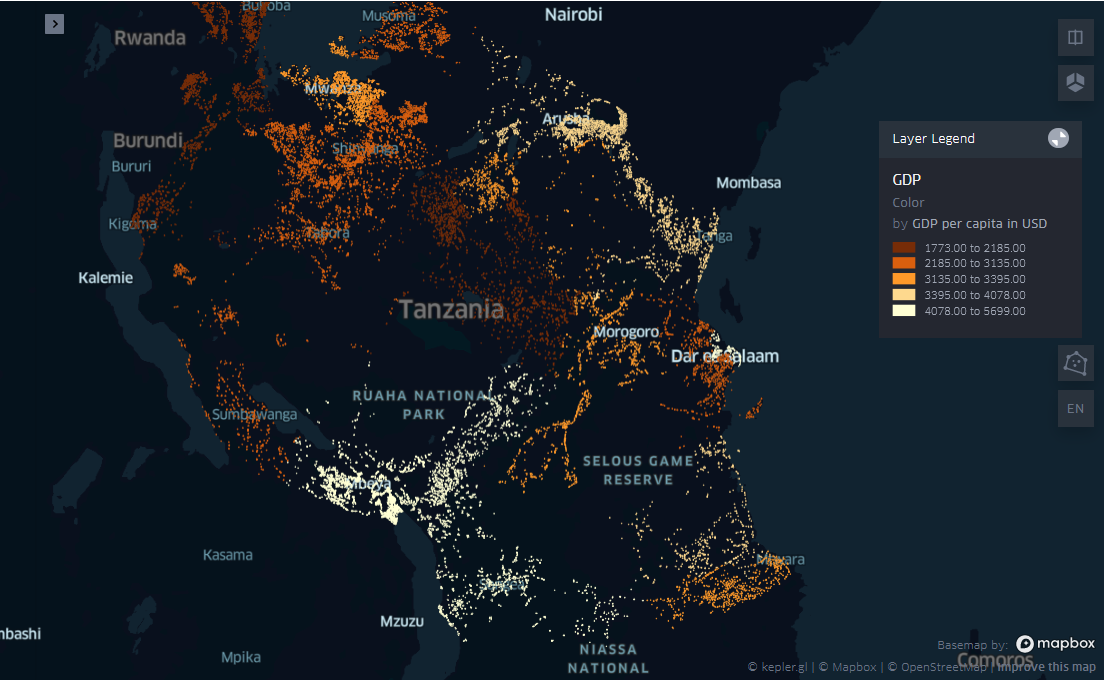

                                 OLS Regression Results                                
Dep. Variable:                     id   R-squared (uncentered):                   0.790
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              75.31
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                    3.24e-08
Time:                        21:19:31   Log-Likelihood:                         -175.77
No. Observations:                  21   AIC:                                      353.5
Df Residuals:                      20   BIC:                                      354.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

Text(0, 0.5, 'Number of wells per region')

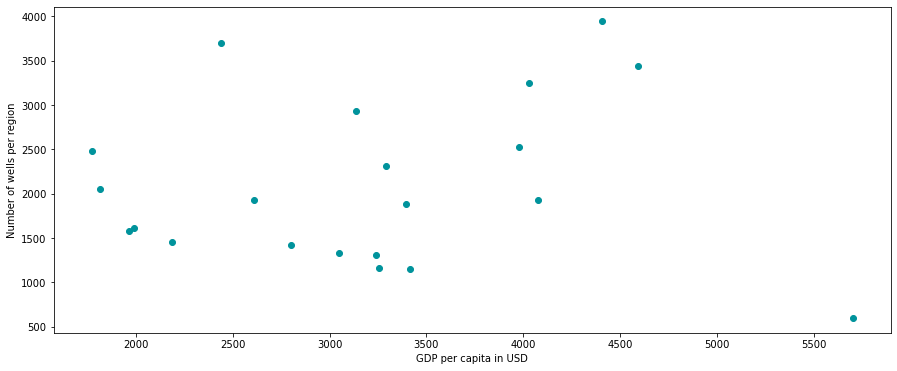

In [16]:
# What is the relation between number of wells in a region and GDP per capita?
# (And number of functioning wells)
df.groupby("region").agg({"GDP per capita in USD": "mean", "id":"count"}).sort_values(by=['GDP per capita in USD'], ascending=False)
df[df["label"] == "functional"].groupby("region").agg({"GDP per capita in USD": "mean", "id":"count"}).sort_values(by=['GDP per capita in USD'], ascending=False)

Y = df.groupby("region")["id"].count()
X = df.groupby("region")["GDP per capita in USD"].mean()

model = sm.OLS(Y, X, missing='drop')
results = model.fit()
print(results.summary())
fig, ax1 = plt.subplots(figsize=(15, 6))
plt.scatter(X,Y, color = "#00939C")
plt.xlabel("GDP per capita in USD")
plt.ylabel("Number of wells per region")

In order to assess the water pump availability further, the number of functioning wells in a region was assessed versus the GDP per capita. In the OLS regression shown above, we can see that there is a highly significant positive correlation between GDP per capita and the number of pumps in a region, with 0.6051 more pumps per dollar of GDP increase per capita. This hints at more pump availability for richer regions. We have to ask ourselves if the pumps are optimally allocated across the country. The outlier in the scatter plot above is the capital region of Dar-es-Salaam, which is a relatively small area in the country and thus has fewer pumps.

Text(0.5, 1.0, 'Average GDP per capita by water quality')

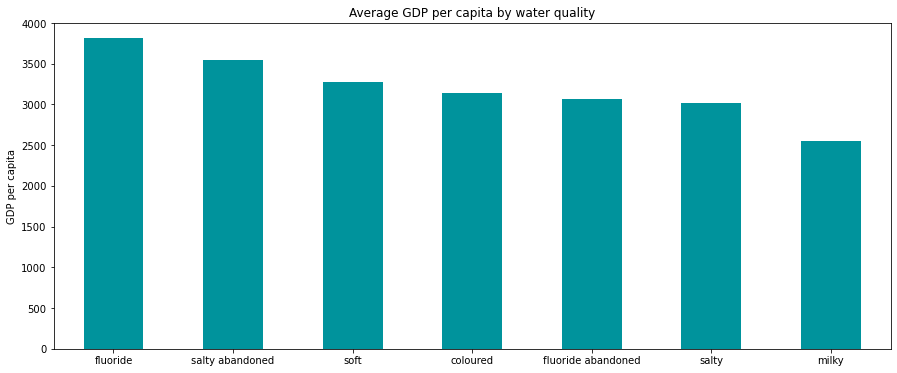

In [17]:
#Average GDP per capita per water quality
GDP_quality = df.groupby('water_quality')['GDP per capita in USD'].mean().sort_values(ascending = False)
piv_table = df.pivot_table(index=['water_quality'],columns = ['label'],
                           values=['GDP per capita in USD'], aggfunc='mean')


#Plotting GDP per capita by water quality
GDP_quality.plot(kind = 'bar', figsize = (15,6), color = "#00939C" )
plt.xlabel("")
plt.xticks(rotation = 0)
plt.ylabel("GDP per capita")
plt.title("Average GDP per capita by water quality")

Text(0.5, 1.0, 'Average GDP per capita by quantity')

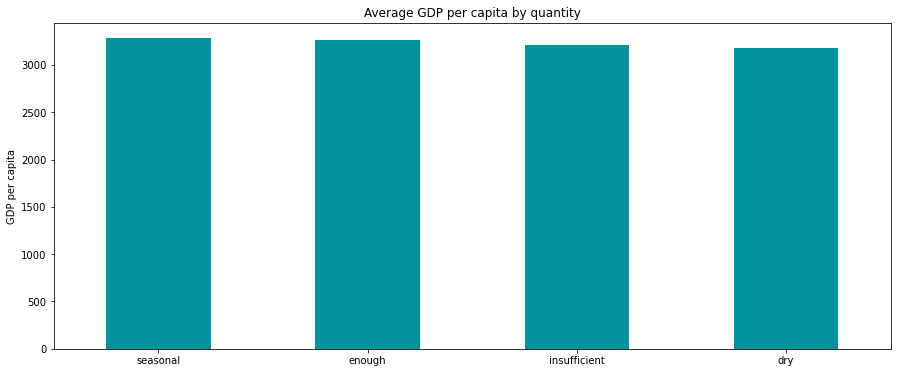

In [18]:
#Average GDP per capita per water quantity
GDP_quantity = df.groupby('quantity')['GDP per capita in USD'].mean().sort_values(ascending = False)
piv_table2 = df.pivot_table(index=['quantity'],columns = ['label'],
                           values=['GDP per capita in USD'], aggfunc='mean')


#Plotting GDP per capita by water quality
GDP_quantity.plot(kind = 'bar',color = "#00939C", figsize = (15,6))
plt.xlabel("")
plt.xticks(rotation = 0)
plt.ylabel("GDP per capita")
plt.title("Average GDP per capita by quantity")

Text(0.5, 1.0, 'Average GDP per capita by pump status')

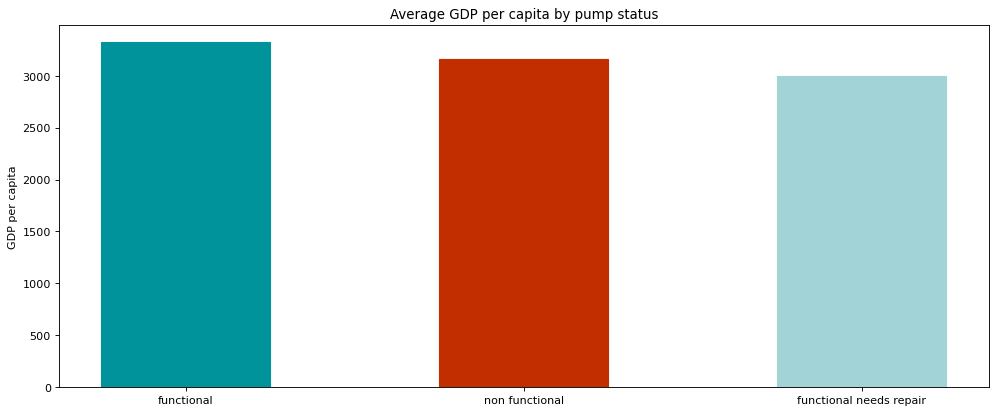

In [19]:
#GDP per Capita in USD per functioning and non functioning pumps
GDP_label = df.groupby('label')['GDP per capita in USD'].mean().sort_values(ascending = False)
y_gdp = GDP_label.values
x_gdp = GDP_label.index.values

#Plotting GDP per capita by functioning and non functioning pumps
figure(figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
barlist = plt.bar(x_gdp, y_gdp, width = 0.5)
barlist[0].set_color(colors_fct[0])
barlist[1].set_color(colors_fct[1])
barlist[2].set_color(colors_fct[2])
plt.xticks(rotation = 0)
plt.ylabel("GDP per capita")
plt.title("Average GDP per capita by pump status")

We can observe that functional pumps tend to be located in areas where GDP is higher on average. A test statistic will tell us if the difference is significant.


In [20]:
#T-test to check if there is a statiscal significance in the difference in mean in GDP per capita between Functional and non functional pumps 
summary, results = rp.ttest(group1= df['GDP per capita in USD'][df['label'] == 'functional'], group1_name= "functional",
                            group2= df['GDP per capita in USD'][df['label'] == 'non functional'], group2_name= "non functional")

print(results)
#Statiscally significant

#T-test to check if there is a statiscal significance in the difference in mean in GDP per capita between Functional and functional needs repair pumps 

summary, results = rp.ttest(group1= df['GDP per capita in USD'][df['label'] == 'functional'], group1_name= "functional",
                            group2= df['GDP per capita in USD'][df['label'] == 'functional needs repair'], group2_name= "fucntional needs repair")

print(results)
#Statiscally significant

                            Independent t-test     results
0  Difference (functional - non functional) =     164.4780
1                        Degrees of freedom =   40811.0000
2                                         t =      17.3804
3                     Two side test p value =       0.0000
4                    Difference < 0 p value =       1.0000
5                    Difference > 0 p value =       0.0000
6                                 Cohen's d =       0.1746
7                                 Hedge's g =       0.1746
8                             Glass's delta =       0.1714
9                                         r =       0.0857
                                  Independent t-test     results
0  Difference (functional - fucntional needs repa...    322.9405
1                              Degrees of freedom =   27093.0000
2                                               t =      17.8383
3                           Two side test p value =       0.0000
4                         

From the test statistic we can observe a significant difference in average GDP per capita between functional pumps and non functional and those that need repairs.

## 4.2 Geographical factors

In [21]:
# Currently faculty does not appear to support the kepler.gl module, therefore the image that have been
# created using the tool will be uploaded manually as image file within the notebook
from keplergl import KeplerGl
map_1 = KeplerGl(height=600, data={"data_1": df}, config = map_config_launch)
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wabd8ws', 'type': …

Overview of the pumps per functionality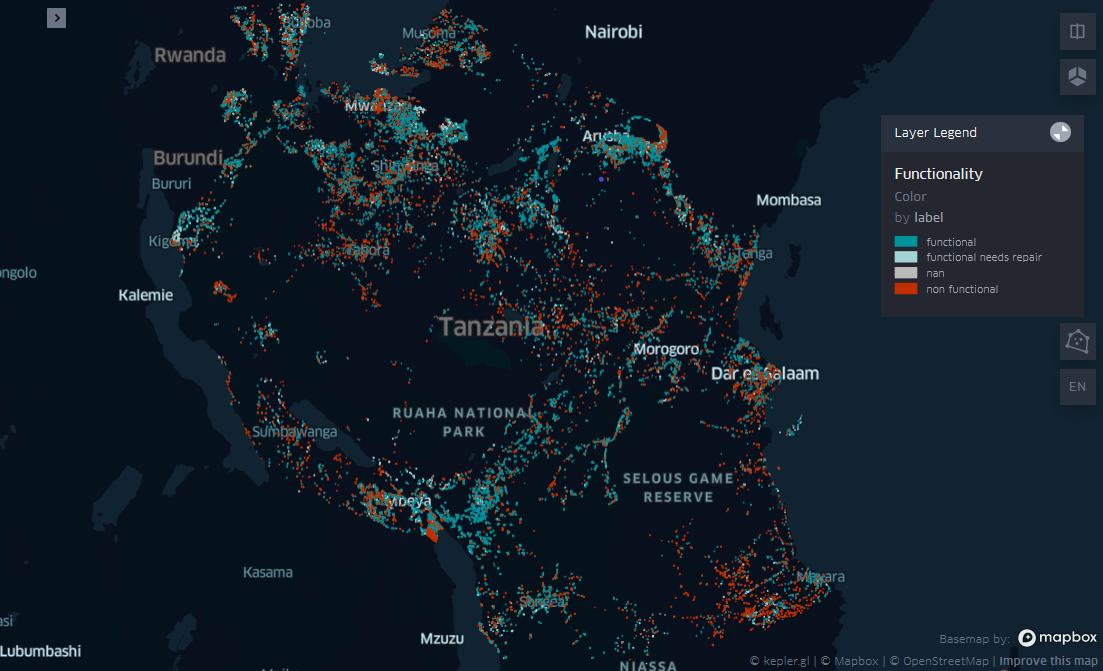

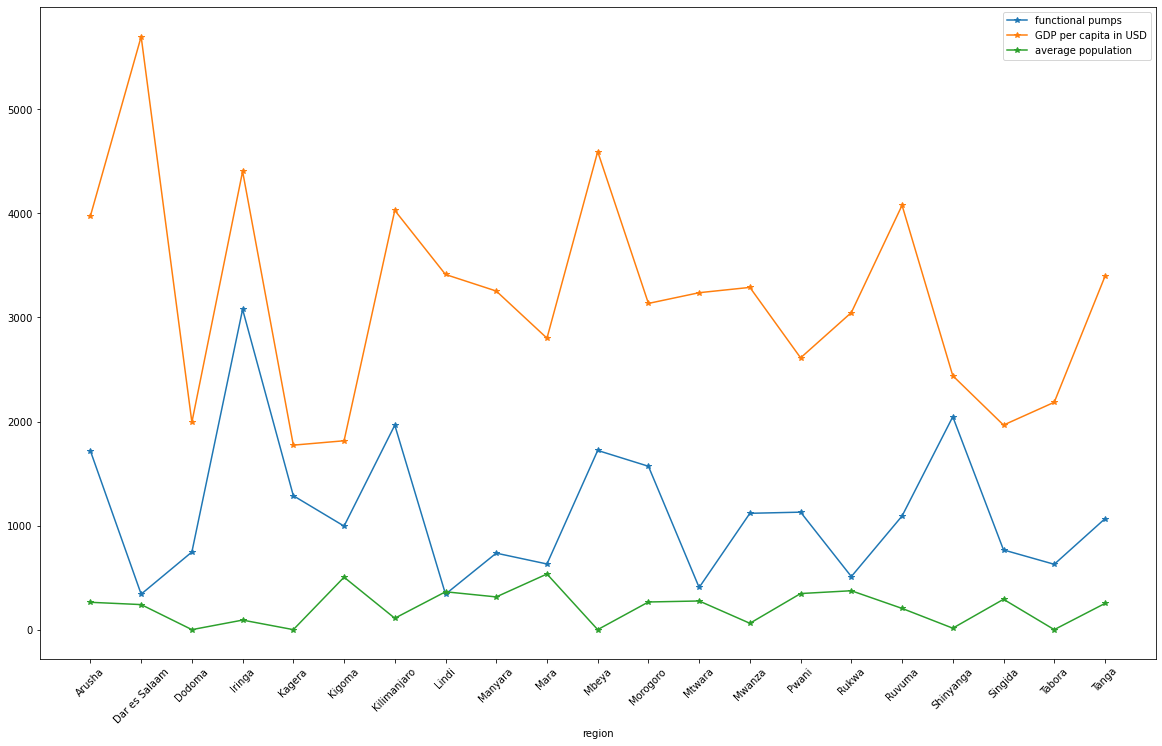

In [22]:
#Creating a data frame with only the functional pumps
df_functional = df[df['label'] == 'functional']

#Creating a merged pivot table to have the the average GDP per capita, average population and the number of functioning pumps by region
piv_table = df_functional.pivot_table(index='region', values= 'label', aggfunc = 'count')
piv_table2 = df.pivot_table(index='region',
                           values=['GDP per capita in USD','population'], aggfunc='mean')

#Plotting the pivot table
fig, ax1 = plt.subplots(figsize=(20, 12))
all_data = pd.merge(piv_table, piv_table2, 'left', on = ['region'])
ax1.plot(all_data, marker = "*")
plt.legend(['functional pumps', 'GDP per capita in USD' , 'average population'])
plt.xlabel('region')
plt.xticks(rotation = 45)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text major ticklabel objects>)

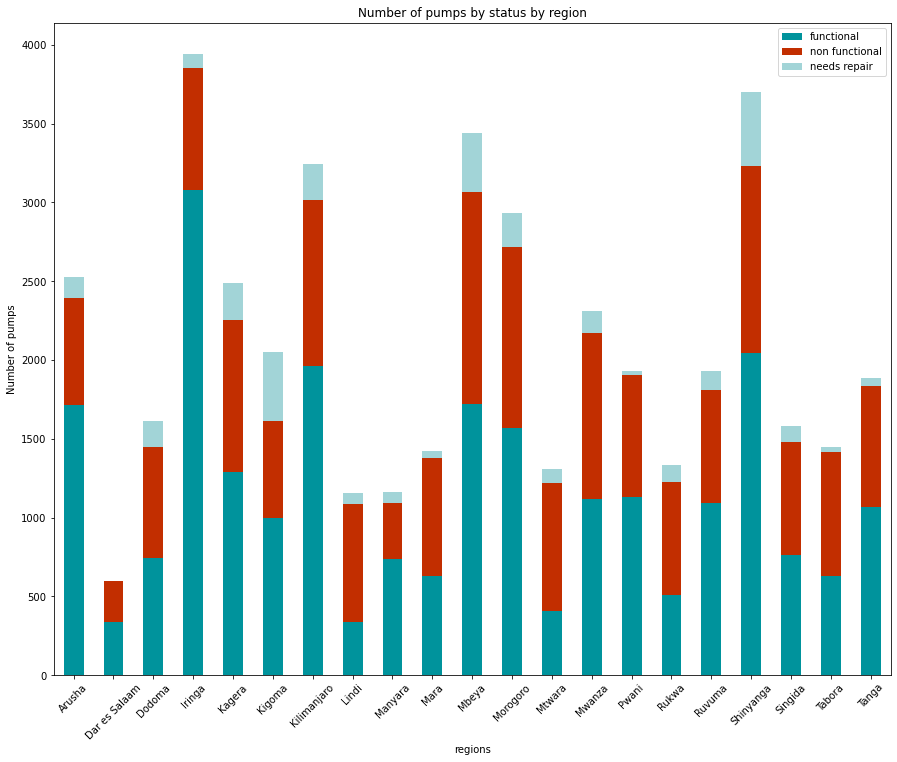

In [23]:
#Data Frame non functional
df_non_functional = df[df['label'] == 'non functional']
df_repairs = df[df['label'] == 'functional needs repair']

#Pivot tables for all status
piv_table3 = df_functional.pivot_table(index=['region'],
                           values=['label'], aggfunc='count')
piv_table4 = df_non_functional.pivot_table(index=['region'],
                           values=['label'], aggfunc='count')
piv_table5 = df_repairs.pivot_table(index=['region'],
                           values=['label'], aggfunc='count')

#merging tables
piv_merged2 = pd.merge(piv_table3, piv_table4, 'right', on = ['region'])
piv_merged3 = pd.merge(piv_merged2, piv_table5, 'right', on =['region'])
piv_merged3.columns = ['functional', 'non functional', 'needs repair']
pal = ["#00939C","#C22E00",  "#A2D4D7"]
piv_merged3.plot(kind='bar', stacked=True, color = pal, figsize=(15, 12))
plt.title('Number of pumps by status by region')
plt.ylabel('Number of pumps')
plt.xlabel('regions')
plt.xticks(rotation = 45)

There is no obvious pattern between number of functioning pumps by region and average population. However, we can observe that the wealthiest region such as Iringa, Mbeya, Kilimanjaro and Shinyanga tend to have the most functioning pumps.

## 4.3 Water factors

Firstly, the number of pumps per climate zone in Tanzania are examined, where the climate classification is matched by region. This is in order to understand if more pumps are present in those regions where less precipitation occurs and thus more pumps may be needed for irrigation or household use.

<BarContainer object of 4 artists>

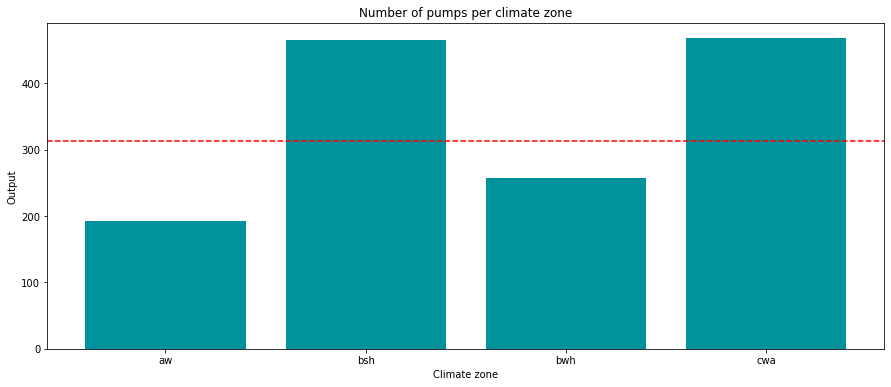

In [24]:
# How are outputs per well in different climate zones?
wells_per_climate_zone = df.groupby("koeppen_classification")["amount_tsh"].mean()
wells_per_climate_zone
f, ax = plt.subplots(figsize=(15,6))
plt.xlabel("Climate zone")
plt.ylabel("Output")
plt.axhline(y=313.07,color='red',linestyle='dashed')
plt.title("Number of pumps per climate zone")
plt.bar(wells_per_climate_zone.index, wells_per_climate_zone.values, color = "#00939C")

We can see that the bsh and cwa climate zones have more than 1.5 times the country-wide average number of pumps. Since these zones have hot semi-arid and monsoon-influenced subtropical climates respectively, while the other two climates are dry, we can see that zones that are (at least seasonally) dry, have a lower number of pumps. This is further supported by the fact that aw (tropical savannah climate) spans by far the biggest part of the country, but still receives considerably less pumps. We thus have to assume that dry regions are less served by pumps, while the wetter ones offer more. This might be due to higher population densities and higher agricultural use of those fertile wet lands.



The next factor we look at is the quality of the water and its impact on the functionality of the pumps.

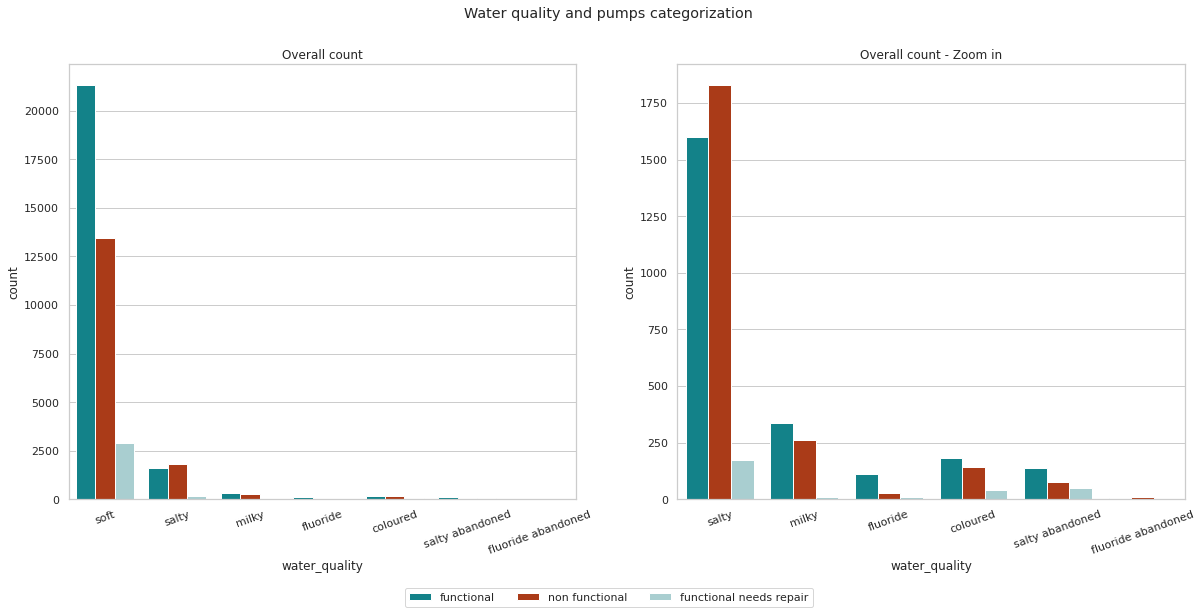

In [25]:
# Set main figure parameters
sns.set(style='whitegrid', palette=pal)
graph_dim = (20,8)
legend_ft_size = 9
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = graph_dim)
fig.suptitle('Water quality and pumps categorization')

# Create necessary dataframes for the analysis
df_quality = df.groupby(['water_quality','label'])['water_quality'].count().unstack(level=1)
df_quality_t = df_quality.fillna(0).astype(int).transpose()
df_quality_pct = df.groupby("water_quality")["label"].value_counts(normalize=True)
df_quality_pct = df_quality_pct.mul(100)
df_quality_pct = df_quality_pct.rename('percent').reset_index()
cols = [x for x in df["water_quality"].unique() if str(x) != 'nan']
cols

# Observe the number of pumps per water quality type across all pumps and impact on function
g_1 = sns.countplot(x = "water_quality", hue = 'label', data = df, 
              order = cols, ax=axes[0])
g_1.legend([],[], frameon=False)
axes[0].set_title("Overall count")

for item in g_1.get_xticklabels():
    item.set_rotation(20)

g_2 = sns.countplot(x = "water_quality", hue = 'label', data = df[-(df.water_quality == 'soft')],
              ax=axes[1])
g_2.legend([],[], frameon=False)
axes[1].set_title("Overall count - Zoom in")

for item in g_2.get_xticklabels():
    item.set_rotation(20)

# Create legend for the two graphs
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels,loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, borderaxespad=2, ncol=len(labels))
plt.show()

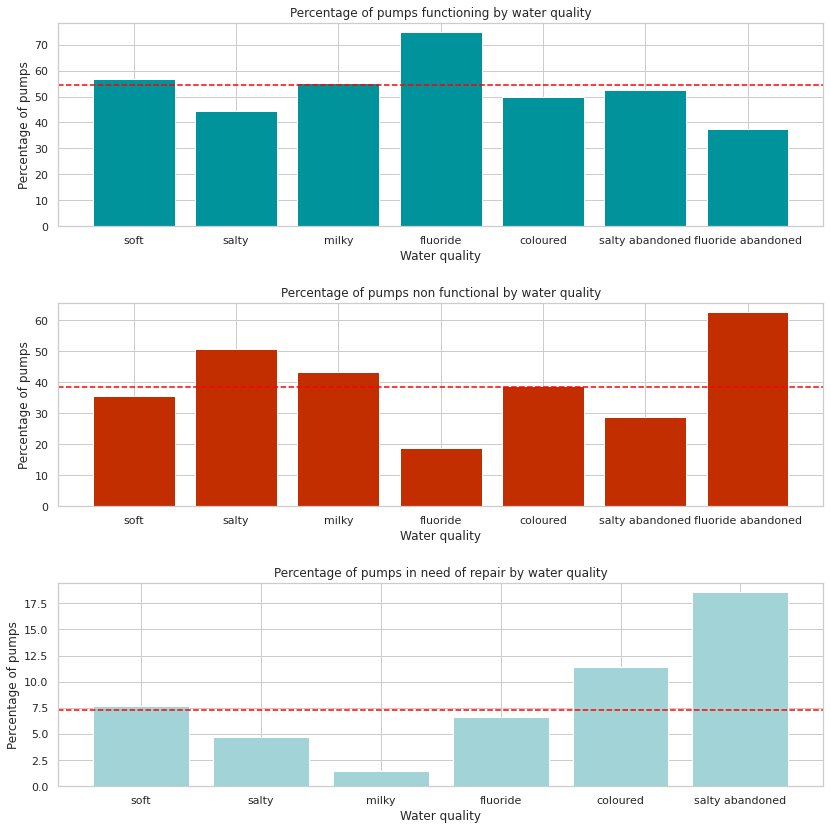

In [26]:
## Create dataframes per functionality
df_quality_pct_fct = df_quality_pct.loc[df_quality_pct['label'] == "functional"]
df_quality_pct_fct.set_index('water_quality', inplace=True)
df_quality_pct_fct = df_quality_pct_fct.reindex(cols)
df_quality_pct_nfct = df_quality_pct.loc[df_quality_pct['label'] == "non functional"]
df_quality_pct_nfct.set_index('water_quality', inplace=True)
df_quality_pct_nfct = df_quality_pct_nfct.reindex(cols)
df_quality_pct_fctr = df_quality_pct.loc[df_quality_pct['label'] == "functional needs repair"]
df_quality_pct_fctr.set_index('water_quality', inplace=True)
df_quality_pct_fctr = df_quality_pct_fctr.reindex(cols)

# Plot all dataframes within one figure
plt.figure(figsize=(12,12))

# Dataframe for functioning pumps
plt.subplot(3,1,1)
quality_f = plt.bar(df_quality_pct_fct.index,df_quality_pct_fct['percent'], color = colors_fct[0])
plt.xlabel("Water quality")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps functioning by water quality")
plt.axhline(y=54.3,color='red',linestyle='dashed')

# Dataframe for non-functioning pumps
plt.subplot(3,1,2)
quality_f = plt.bar(df_quality_pct_nfct.index,df_quality_pct_nfct['percent'], color = colors_fct[1])
plt.xlabel("Water quality")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps non functional by water quality")
plt.axhline(y=38.4,color='red',linestyle='dashed')

# Dataframe for functioning pumps needing repair
plt.subplot(3,1,3)
quality_f = plt.bar(df_quality_pct_fctr.index,df_quality_pct_fctr['percent'], color = colors_fct[2])
plt.xlabel("Water quality")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps in need of repair by water quality")
plt.axhline(y=7.3,color='red',linestyle='dashed')

plt.tight_layout(pad=2.0)

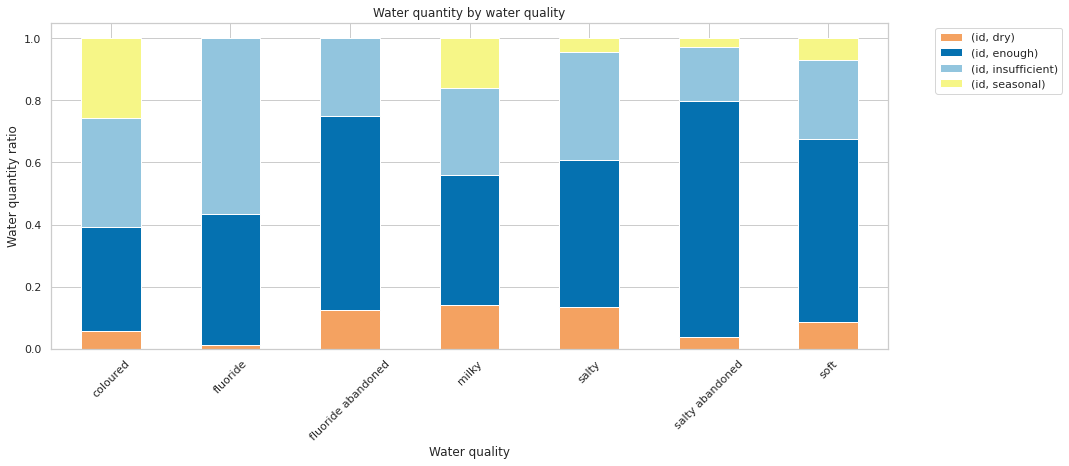

In [27]:
#Relationship between Water Quality and Water Quantity
color_qt = ["#F4A261", "#0571B0", "#92C5DE", "#F6F687"]
piv_df= df[['id','water_quality','quantity']]
piv_table = piv_df.pivot_table(index='water_quality',
                           columns='quantity', aggfunc='count')

total = df.groupby("water_quality")['quantity'].count()

#Create a pivot table with ratios
piv_table2 = piv_table.div(total, axis=0 )


#Relationship between quater quantity and label
piv_df3= df[['label','water_quality', 'id']]
piv_table3 = piv_df3.pivot_table(index='water_quality',
                           columns='label', aggfunc='count')

total = df.groupby("water_quality")['label'].count()
piv_table4 = piv_table3.div(total, axis = 0)

#Plotting graphs
piv_table2.plot(kind='bar', stacked = True, figsize = (15,6), color = color_qt)
plt.title("Water quantity by water quality")
plt.ylabel("Water quantity ratio")
plt.xlabel("Water quality")
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

We observe that the water quality does have an impact on the functioning of the pumps. Pumps with soft and fluroride water are more likely to be functional compared to salty or milky pumps. Salt is corrosive to pipes, and therefore more likely to cause breakdowns. On the other hand, milky water can be interpreted as a consequence of a breakdown, as it signals air bubbles in the water, and is usually caused by tears in the pipes.

However, we can't observe any specific relationship between the water quantity and the functionning of the pumps. If we look at the fluoride water, we can oberseve that around 60% of the pumps have water drained that is insufficent whereas around 75% of the pumps are functional.

## 4.4 Water pumps characteristics

There are several variables in the data that describe technical or other pump specific features such as managment and payment. 

## Pump age

There are 53 distinct values for the age of the pumps, which have been constructed from 1960 to 2013. By plotting the functionality of pumps by their age, it can be concluded that newer pumps are more likely to function than older pumps, generally speaking. This is a intuitive conclusion, but might be useful when creating a predictive model.

In [28]:
#Getting some basic info on the age variable
df["construction_year"].describe()
df["age_pump"].describe()

count    44013.000000
mean        13.988731
std         10.269773
min          0.000000
25%          8.000000
50%         11.000000
75%         16.000000
max         53.000000
Name: age_pump, dtype: float64

In [29]:
#Grouping functionality by age and create a subset of data
func_by_age=df.groupby(["age_pump","label"]).size().unstack()
func_by_age['total']=func_by_age.sum(axis=1)

#Replacing the values in the subset by proportions 
for column in func_by_age:
    if column=='total':
        break
    func_by_age[column]=(func_by_age[column]/func_by_age['total']).round(decimals=2)

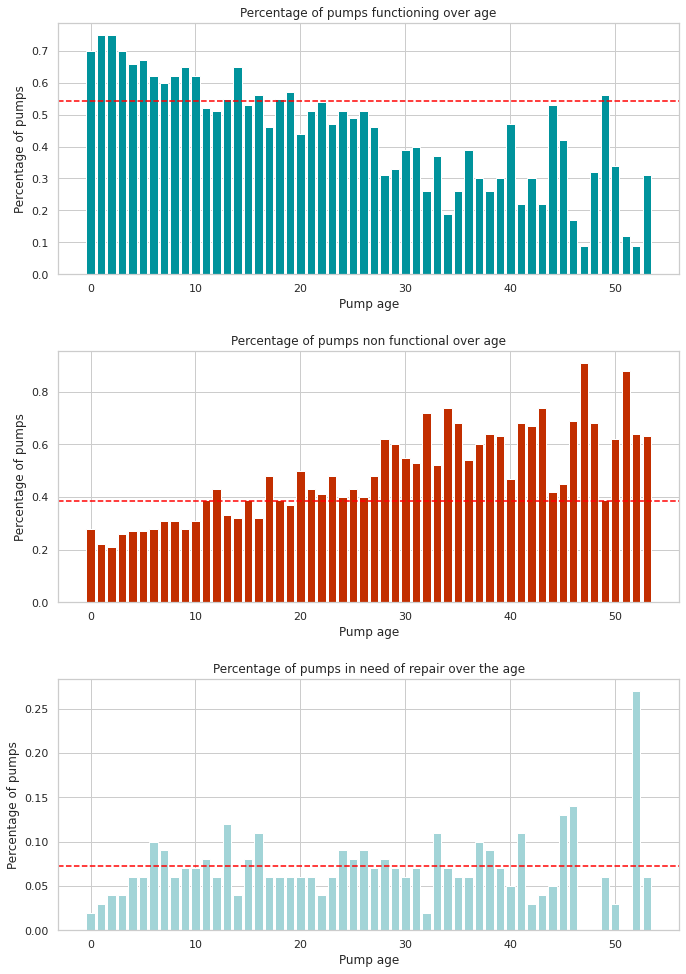

In [30]:
plt.figure(figsize=(10,14))

plt.subplot(3,1,1)
f=plt.bar(func_by_age.index,func_by_age['functional'], color = colors_fct[0])
plt.xlabel("Pump age")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps functioning over age")
plt.axhline(y=0.543,color='red',linestyle='dashed')

plt.subplot(3,1,2)
nf=plt.bar(func_by_age.index,func_by_age['non functional'], color = colors_fct[1])
plt.xlabel("Pump age")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps non functional over age")
plt.axhline(y=0.384,color='red',linestyle='dashed')

plt.subplot(3,1,3)
nr=plt.bar(func_by_age.index,func_by_age['functional needs repair'], color = colors_fct[2])
plt.xlabel("Pump age")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps in need of repair over the age")
plt.axhline(y=0.073,color='red',linestyle='dashed')

plt.tight_layout(pad=2.0)
plt.show()

## Waterpoint type

This variable indicates the type of pump, which has 6 distinct values. The vast majority of pumps are communal standpipes, while the smallest proportion of pumps are dams. Dams perform the best, but only represent 5 observations in the data. This makes sense, since dams are very capital intensive projects which require a lot of maintenance. The most common well-performing type is communal standpipes, which is achieving above the benchmark of 54.3%.

In [31]:
df['waterpoint_type_group'].describe()
df['waterpoint_type_group'].value_counts()

communal standpipe    25665
hand pump             12975
other                  4700
improved spring         583
cattle trough            92
dam                       5
Name: waterpoint_type_group, dtype: int64

In [32]:
func_by_wtp=df.groupby(["waterpoint_type_group","label"]).size().unstack()
func_by_wtp['total']=func_by_wtp.sum(axis=1)

#Replacing the values in the subset by proportions 
for column in func_by_wtp:
    if column=='total':
        break
    func_by_wtp[column]=(func_by_wtp[column]/func_by_wtp['total']).round(decimals=2)

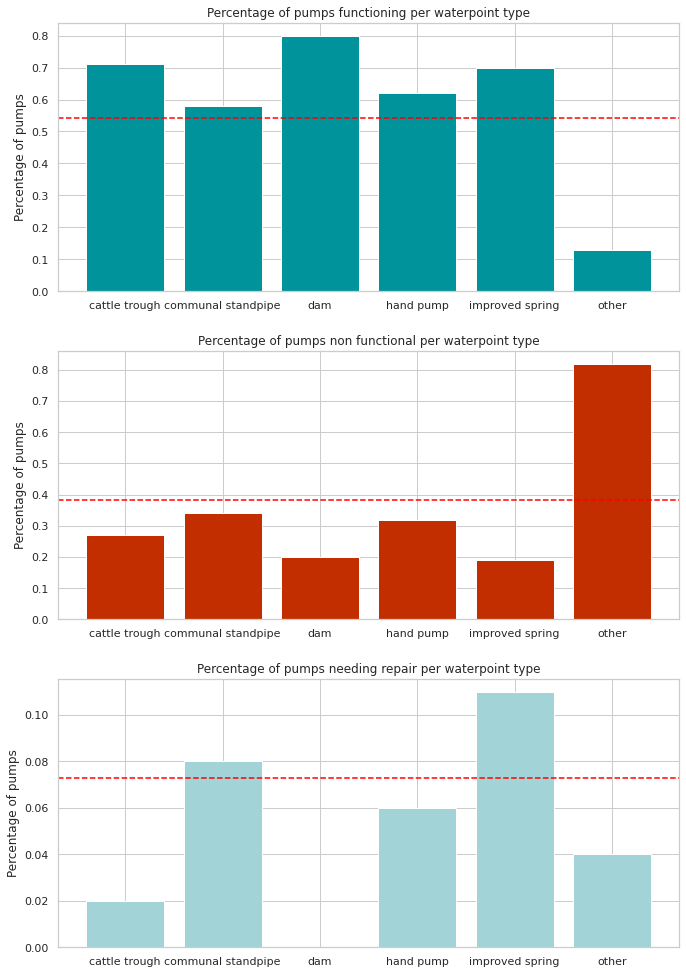

In [33]:
plt.figure(figsize=(10,14))

plt.subplot(3,1,1)
f=plt.bar(func_by_wtp.index,func_by_wtp['functional'], color = colors_fct[0])
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps functioning per waterpoint type")
plt.axhline(y=0.543,color='red',linestyle='dashed')

plt.subplot(3,1,2)
nf=plt.bar(func_by_wtp.index,func_by_wtp['non functional'], color = colors_fct[1])
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps non functional per waterpoint type")
plt.axhline(y=0.384,color='red',linestyle='dashed')

plt.subplot(3,1,3)
nr=plt.bar(func_by_wtp.index,func_by_wtp['functional needs repair'], color = colors_fct[2])
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps needing repair per waterpoint type")
plt.axhline(y=0.073,color='red',linestyle='dashed')

plt.tight_layout(pad=2.0)
plt.show()

## Extraction type

The extraction type variable describes the method of extraction used at the pumps. This variable has 7 unique categories. Handpumps do well, whereas motor and wind-powered pumps underperform. This might be due to the technical components breaking down more easily with motor and wind-powered pumps.

In [34]:
df["extraction_type_class"].describe()
df["extraction_type_class"].value_counts()

gravity         19817
handpump        12205
other            4753
submersible      4584
motorpump        2237
rope pump         339
wind-powered       85
Name: extraction_type_class, dtype: int64

In [35]:
func_by_extr=df.groupby(["extraction_type_class","label"]).size().unstack()
func_by_extr['total']=func_by_extr.sum(axis=1)

#Replacing the values in the subset by proportions 
for column in func_by_extr:
    if column=='total':
        break
    func_by_extr[column]=(func_by_extr[column]/func_by_extr['total']).round(decimals=2)

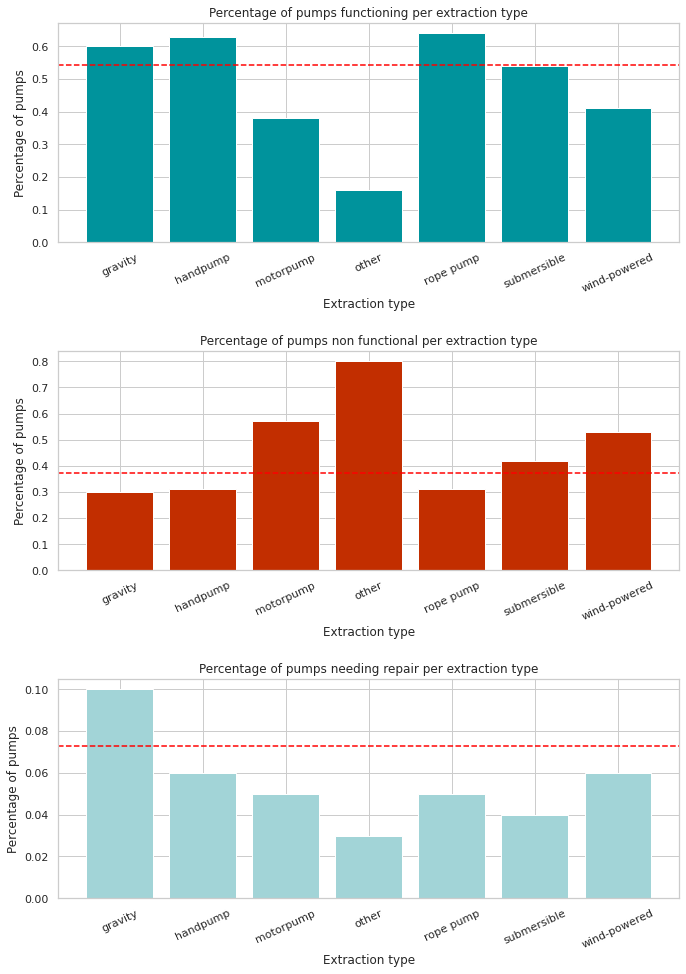

In [36]:
plt.figure(figsize=(10,14))

plt.subplot(3,1,1)
f=plt.bar(func_by_extr.index,func_by_extr['functional'], color = colors_fct[0])
plt.xlabel("Extraction type")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps functioning per extraction type")
plt.axhline(y=0.543,color='red',linestyle='dashed')
plt.xticks(rotation=25)

plt.subplot(3,1,2)
nf=plt.bar(func_by_extr.index,func_by_extr['non functional'], color = colors_fct[1])
plt.xlabel("Extraction type")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps non functional per extraction type")
plt.axhline(y=0.374,color='red',linestyle='dashed')
plt.xticks(rotation=25)

plt.subplot(3,1,3)
nr=plt.bar(func_by_extr.index,func_by_extr['functional needs repair'], color = colors_fct[2])
plt.xlabel("Extraction type")
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps needing repair per extraction type")
plt.axhline(y=0.073,color='red',linestyle='dashed')
plt.xticks(rotation=25)

plt.tight_layout(pad=2.0)
plt.show()

## Management

The management variable represents the method of management at each pump. Below, the amount of pumps for each management group is shown. VWC, a governmental organization, is the largest group but underperforms. There are 7 management groups outperforming the benchmark, they account to one third of the total pumps. Management types that are devoted to managing pumps do better, which makes sense intuitively. Organizations like schools, which primary goal is not to provide water, do worse.

In [37]:
df['management'].value_counts()

vwc                 30004
wug                  4820
water board          2171
wua                  1881
private operator     1471
parastatal           1312
water authority       667
other                 632
company               518
other - school         69
trust                  58
Name: management, dtype: int64

In [38]:
func_by_mgt=df.groupby(["management","label"]).size().unstack()
func_by_mgt['total']=func_by_mgt.sum(axis=1)

#Replacing the values in the subset by proportions 
for column in func_by_mgt:
    if column=='total':
        break
    func_by_mgt[column]=(func_by_mgt[column]/func_by_mgt['total']).round(decimals=2)

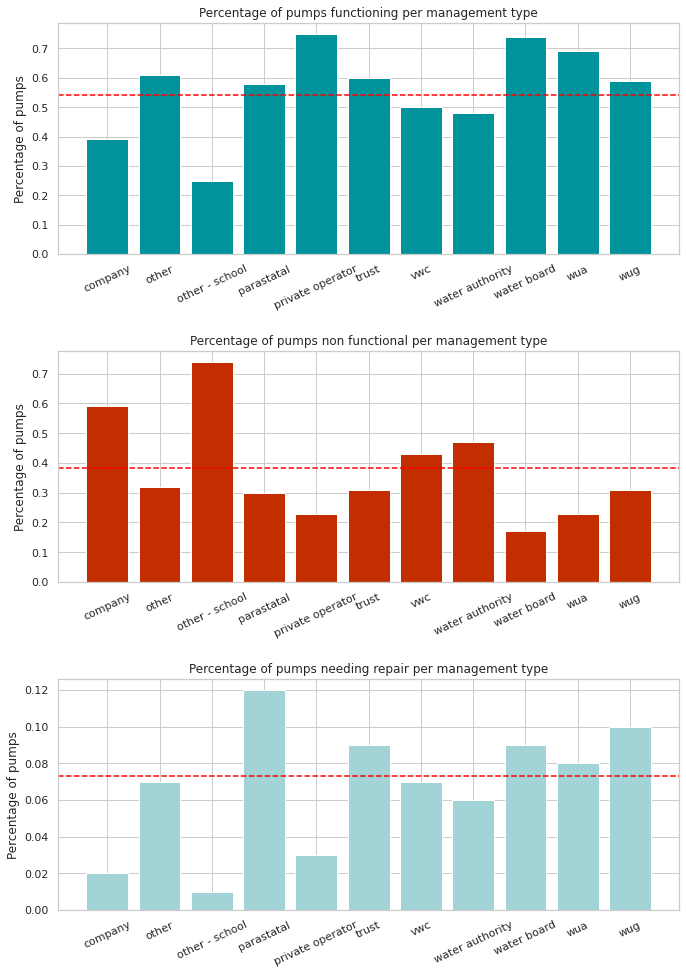

In [39]:
plt.figure(figsize=(10,14))

plt.subplot(3,1,1)
f=plt.bar(func_by_mgt.index,func_by_mgt['functional'], color = colors_fct[0])
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps functioning per management type")
plt.axhline(y=0.543,color='red',linestyle='dashed')
plt.xticks(rotation=25)

plt.subplot(3,1,2)
nf=plt.bar(func_by_mgt.index,func_by_mgt['non functional'], color = colors_fct[1])
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps non functional per management type")
plt.axhline(y=0.384,color='red',linestyle='dashed')
plt.xticks(rotation=25)

plt.subplot(3,1,3)
nr=plt.bar(func_by_mgt.index,func_by_mgt['functional needs repair'], color = colors_fct[2])
plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps needing repair per management type")
plt.axhline(y=0.073,color='red',linestyle='dashed')
plt.xticks(rotation=25)
plt.tight_layout(pad=2.0)
plt.show()

## Payment

The payment variable decribes the payment type for every pump, with 6 distinct payment methods. Most pumps are free, while others are payed for with various different forms. Intuitively, pumps that require a form of payment would be functioning better, which is confirmed here. For non functional pumps, the never pay payment type is the only group exceeding the benchmark. This payment method is also the vast majority of payment methods at pumps.

In [40]:
df['payment_type'].describe()
df['payment_type'].value_counts()

never pay     18757
per bucket     6702
monthly        6116
on failure     2903
annually       2713
other           767
Name: payment_type, dtype: int64

In [41]:
func_by_pay=df.groupby(["payment_type","label"]).size().unstack()
func_by_pay['total']=func_by_pay.sum(axis=1)

for column in func_by_pay:
    if column=='total':
        break
    func_by_pay[column]=(func_by_pay[column]/func_by_pay['total']).round(decimals=2)

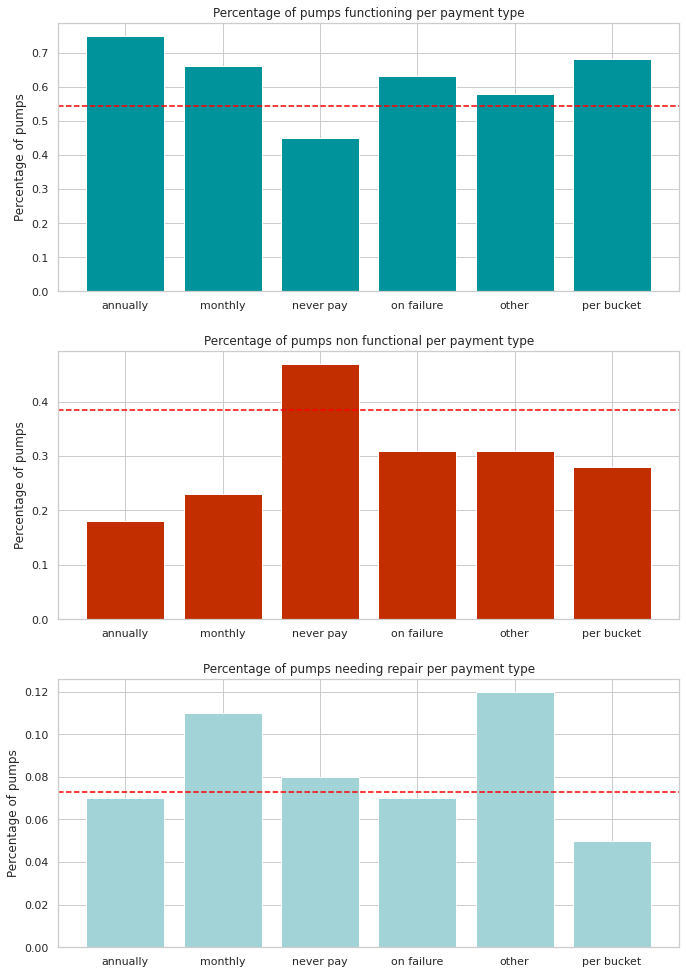

In [42]:
plt.figure(figsize=(10,14))
plt.subplot(3,1,1)
f=plt.bar(func_by_pay.index,func_by_pay['functional'], color = colors_fct[0])

plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps functioning per payment type")
plt.axhline(y=0.543,color='red',linestyle='dashed')
plt.subplot(3,1,2)
nf=plt.bar(func_by_pay.index,func_by_pay['non functional'], color = colors_fct[1])

plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps non functional per payment type")
plt.axhline(y=0.384,color='red',linestyle='dashed')

plt.subplot(3,1,3)

nr=plt.bar(func_by_pay.index,func_by_pay['functional needs repair'], color = colors_fct[2])

plt.ylabel("Percentage of pumps")
plt.title("Percentage of pumps needing repair per payment type")
plt.axhline(y=0.073,color='red',linestyle='dashed')
plt.tight_layout(pad=2.0)
plt.show()

## 4.5  Water Pumps Category

In order to make a better prediction of the pump functionality, we examine who is responsible for funding and installing pumps in Tanzania. However, these data cannot be grouped by organizations directly. According to the Jacob Benoot's report, after careful investigation, data of both funder and installer can be seperated by 7 groups, by categorization on frequently appearing words. The distribution and analytics of funder and installer variables will be based on the new categories. 

In [43]:
# The source of the water can be seperated by pumps characteristics
# funder
g1=df["funder"]
result_funder = pd.DataFrame(g1.value_counts().head(30))
result_funder.columns=['funder']


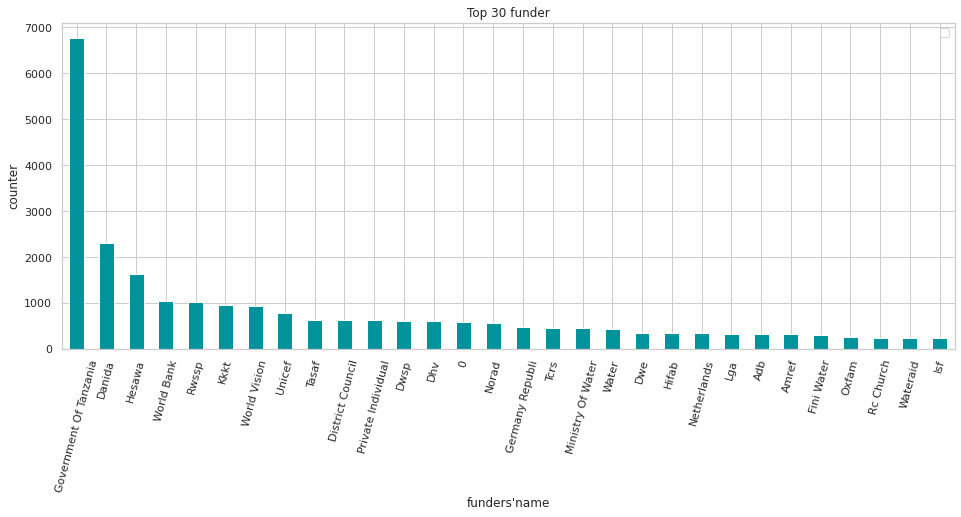

In [44]:
# bar chart of the top 30 funder 
result_funder.plot(kind= 'bar', figsize = (16, 6))
plt.xlabel('funders\'name')
plt.ylabel('counter')
plt.xticks(rotation = 75)
plt.title("Top 30 funder")
plt.legend("")

In [45]:
# installer
g2 = df["installer"]
result_installer=pd.DataFrame(g2.value_counts().head(30))

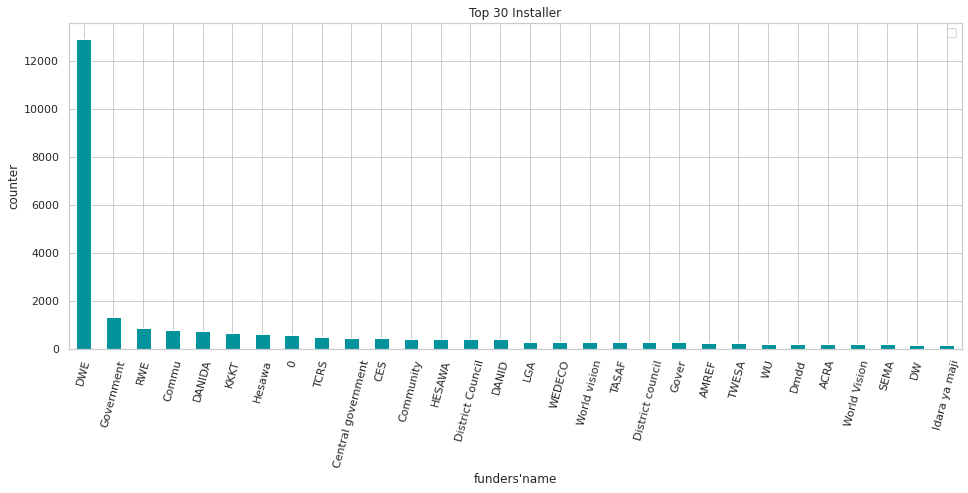

In [46]:
# bar chart of the top 30 installer 
result_installer.plot(kind = 'bar', figsize = (16,6))
plt.xlabel('funders\'name')
plt.ylabel('counter')
plt.xticks(rotation = 75)
plt.title("Top 30 Installer")
plt.legend("")

#Government Supply:
#LGA: Local government authority
#DWE: District Water Engineering
#DWSP: Domestic Water Supply
#TASAF: Tanzanian social action fund
#RWSSP: Rural water supply and sanitation programme
#WSDP: Water sector development programme
#DMDD: Diocese of Mbulu Development Department

We use top 30 organizations in both funder and installer dataframes to represent the whole distributions.
The bar charts indicate Tanzanian government may be the biggest pumps supplier.

In [47]:
r1 = result_installer.T
r2 = result_funder.T

In [48]:
# funder
Gov_funder=r2[['Government Of Tanzania','Rwssp','Dwe','Dwsp','Tasaf','District Council']]
Gov_nfunder=Gov_funder.sum(axis=1)

In [49]:
# installer
gov_instal = r1[['Government','Gover','LGA','DWE','Dmdd','TASAF',
                 'District Council','Central government','District council']]
gov_ninstal=gov_instal.sum(axis=1)

In [50]:
# funder
inter_funder=r2[['Hifab','Norad','Hesawa','Danida','Netherlands','Germany Republi']]
inter_nfunder=inter_funder.sum(axis=1)

#International Investment:
#HIFAB: Swedish project management consultants NORAD: Norwegian agency for development
#HESAWA: Swedish - Tanzanian
#cooperation DANIDA: Danish-Tanzanian cooperation
#RUDEP: rural development programma, Norwegian initiative
#CES(GMBH): Consulting Engineers Salzgitter GmbH (CES)
#JICA/JAICA: japan international cooperation agency

In [51]:
# installer
inter_instal=r1[['CES','HESAWA','Hesawa','World vision','World Vision']]
inter_ninstal=inter_instal.sum(axis=1)

In [52]:
# funder
Religious_funder=r2[['Kkkt','Tcrs','Rc Church']]
Religious_nfunder=Religious_funder.sum(axis=1)

#Religious Initiatives:
#KKKT: Kanisa la Kiinjili la Kilutheri Tanzania, lutherean church in tanzania
#TCRS: Tanganyika Christian Refugee Service

In [53]:
# installer
Religious_instal=r1[['KKKT','TCRS']]
Religious_ninstal=Religious_instal.sum(axis=1)

In [54]:
# funder
Private_funder=r2[['Private Individual']]
Private_nfunder=Private_funder.sum(axis=1)

#Private:
#Entries containing: “Private”, “private company”, “private individual”

In [55]:
# installer
community_instal=r1[['TWESA','SEMA','Commu','Community']]
community_ninstal=community_instal.sum(axis=1)

#Community/local efforts:
#SHIPO: ngo in Tanzania
#TWESA: ngo in Tanzania
#SEMA: ngo in Tanzania
#Entries containing: “village”, ”municipal”,” local”, “community”

In [56]:
# funder
Aid_funder=r2[['Adb','Amref','Wateraid','Oxfam','World Bank','World Vision']]
Aid_nfunder=Aid_funder.sum(axis=1)

#Aid:
#Red cross, Oxfam, unicef, world bank, world vision ADB: African Development bank
#AMREF: Amref flying doctors
#ADRA: ngo of italy
#ACRA: Community development and emergency relief

In [57]:
# installer
aid_instal=r1[['ACRA','AMREF','World vision','World Vision']]
aid_ninstal=aid_instal.sum(axis=1)

### Others

In [58]:
Other = result_funder.loc['0']
count_o = sum(Other)

In [59]:
other = result_installer.loc['0']
count_O = sum(other)

## Visualization of Water Source 

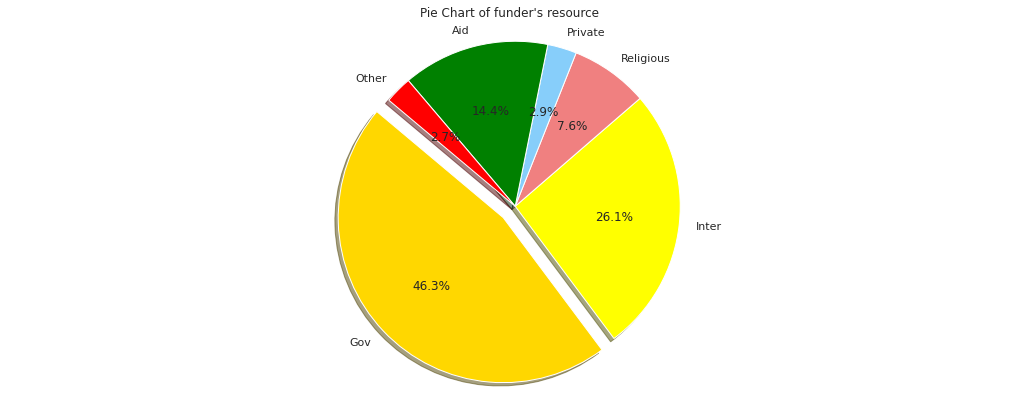

In [60]:
# Pie Chart of funder's resource
f, ax = plt.subplots(figsize=(18,7))
labels  = ['Gov','Inter','Religious','Private','Aid','Other']
sizes = [Gov_nfunder,inter_nfunder,Religious_nfunder,Private_nfunder,Aid_nfunder,count_o]
colors = ['gold', 'yellow', 'lightcoral', 'lightskyblue','green','red']
explode = (0.1, 0, 0, 0,0,0) 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Pie Chart of funder\'s resource')
plt.show()

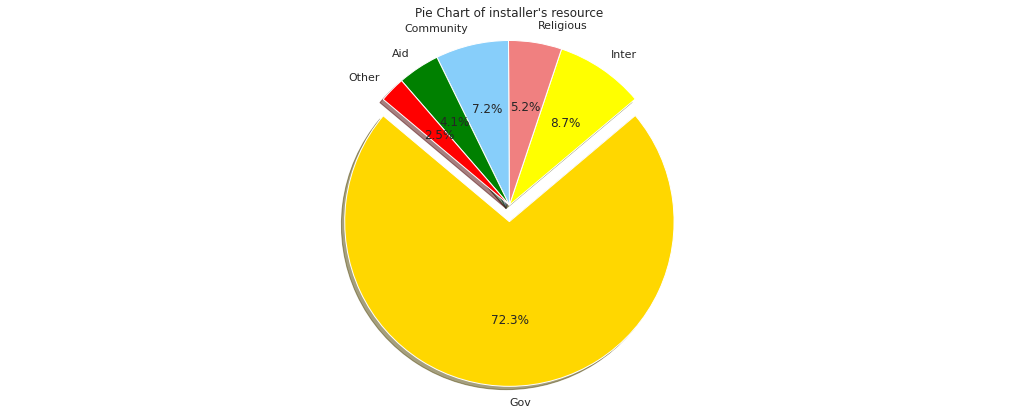

In [61]:
# Pie Chart of installer's resource
f, ax = plt.subplots(figsize=(18,7))
labels  = ['Gov','Inter','Religious','Community','Aid','Other']
sizes = [gov_ninstal,inter_ninstal,Religious_ninstal,community_ninstal,aid_ninstal,count_O]
colors = ['gold', 'yellow', 'lightcoral', 'lightskyblue','green','red']
explode = (0.1, 0, 0, 0,0,0) 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Pie Chart of installer\'s resource')
plt.show()

These two pie chats indicates government contributes most in both funding and installing water pumps in Tanzania, with the international group in second place, containing of organizations such as World Vision. 
We will focus on funders and installers in the modelling.

# 5. Modelling

## Predictive Analytics

This section will use predictive analytics to forecast whether pumps are functional based on the various predictors available in the data. We have made a selection of 15 predictor variables based on their importance in the exploratory analysis, which can be seen as "categorical" and "continuous" in the code cell below. Due to the binary class distribution we are interested in, a logistic regression classifier is used first as a simple model. Afterwards, a random forest regressor is used with cross-validation and hyperparameter tuning, since this model often performs relatively well regardless of specific characteristics of the data and eliminates many of the common shortfalls of simpler tree-based models.

To process the data for machine learning models, the target (is the pump functional or not?) is encoded as binary, where functional is the positive (1) and the two types of nun-functional wells are the 0 class. All missing continuous variable observations are converted to 0 and to a numpy array, whereas all categorical missing data is replaced with an "NA" string.

In [62]:
# target variable
target = df.label.to_numpy()
# encode target as 0 and 1
target = np.where(target=="functional", 1, 0)

# predictor variables
# extract columns with categorical data
categorical = df[['funder','installer','region', 'extraction_type_class', 'payment_type',
                  'water_quality', 'quantity', 'source_type', 'waterpoint_type_group', 
                  'koeppen_classification']]
categorical = categorical.fillna("NA")
# extract columns with continuous data
continuous = df[['amount_tsh', 'gps_height', 'population', 'GDP per capita in USD', 'age_pump']]
continuous = continuous.fillna(0)
continuous = continuous.to_numpy()

In [63]:
#Standard scaling is used to account for the very different value ranges across different predictors.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
continuous = scaler.fit_transform(continuous)

In [64]:
# One-hot-encoding is used to create binary dummies of the categorical variables.
encode = OneHotEncoder()
oneHotCats = encode.fit_transform(categorical).toarray()

# concatenate one hot encoded data with continous data
data = np.concatenate((oneHotCats, continuous), axis=1)

At first, a logit model is set up and fitted to the data. This simple model should yield good results depending on the distribution of the functionality classes. In order to account for the class imbalance, classes are weighted before fitting the model. A train-test-split is performed with a split of 30/70%.

In [66]:
# specify logit algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

class_weight = df.label.value_counts()/len(df)
class_weight = {0: 1/class_weight[0], 1: 1/class_weight[1]}

# Separate the dataset into training set and train set
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.3, # fraction of test set
                                                    random_state=1)

algorithm = LogisticRegression(class_weight=class_weight, max_iter=10000)

algorithm.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(algorithm.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(algorithm.score(X_test, y_test)))

# the first column shows the predicted probability that the well is not functioning, the second one that it is functioning
preds = algorithm.predict_proba(data)
# show first 5 rows of preds
preds[:5]

Accuracy of Logistic regression classifier on training set: 0.79
Accuracy of Logistic regression classifier on test set: 0.76


array([[0.04754127, 0.95245873],
       [0.05815649, 0.94184351],
       [0.06663426, 0.93336574],
       [0.9965828 , 0.0034172 ],
       [0.12724763, 0.87275237]])

The distribution of the data seems to have been well-suited for a logistic regression, which yielded a test set accuracy of 76% without hyperparameter tuning. We will examine the precision and recall of the model next.

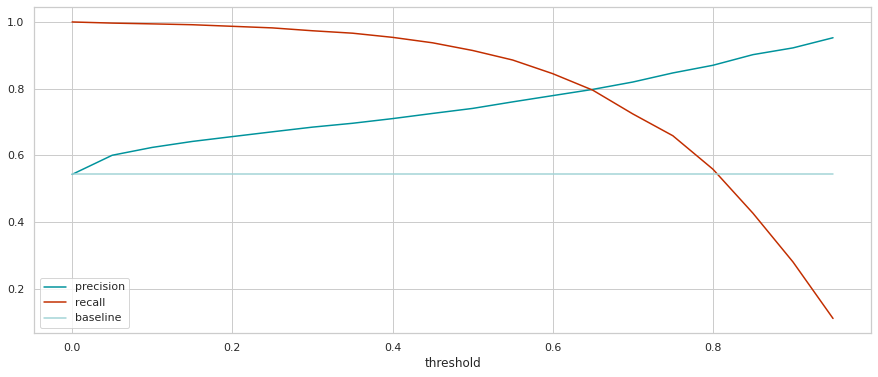

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

contact_preds = preds[:,1]
classify = np.where(preds >= 0.5, 1, 0).flatten()
# baseline performance where we assume all wells are functional
classify.sum()
baseline = target.sum()/len(target)
classify = np.where(contact_preds >= 0.5, 1, 0).flatten()
tn, fp, fn, tp = confusion_matrix(target, classify).ravel()

precision = []
recall = []
ps = []
for p in np.arange(0,1,0.05):
    classify = np.where(contact_preds >= p, 1, 0).flatten()
    tn, fp, fn, tp = confusion_matrix(target, classify).ravel()
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    ps.append(p)

f, ax = plt.subplots(figsize=(15,6))
plt.plot(ps, precision, label='precision');
plt.plot(ps, recall, label='recall');
plt.plot(ps, [baseline]*len(ps), label='baseline');
plt.xlabel("threshold")
plt.legend();
plt.savefig("logit_all_pr.png")

We see a sweetspot between precision and recall above the 50% baseline performance, with a rather smooth decline in recall and a gradual increase in precision.

Following this basic model, a more complex algorithm is fitted below. A random forest classifier should be able to yield a good performance, since the flaws of using models based on a single tree are avoided by generating uncorrelated trees. Hyperparameter tuning with randomized search on the tree depth between 2 and 6 and 3-fold CV are used to optimize the model. Accuracy is evaluated on previously split test data. The number of folds, the tree depth parameter space and the train-test-split were selected with a balance of performance, computational power and the limited number of observations available.

In [68]:
# specify random forest classifier algorithm
from sklearn.ensemble import RandomForestClassifier

algorithm = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.3, # fraction of test set
                                                    random_state=1)

# define paramater space
space = dict()
space['max_depth'] = [int(x) for x in np.linspace(start = 2, stop = 6)]

# choose number of folds
n_folds = 3

# how many times do you want to sample the paramater space?
n_samples = 20

# perform hyperparameter tuning with randomised grid search, plus
# stratified cross validation
clf = RandomizedSearchCV(estimator=algorithm,
                        n_iter=n_samples,
                        param_distributions=space,
                        cv=n_folds,
                        scoring="accuracy",
                        random_state=0,
                        n_jobs=4,
                        pre_dispatch='n_jobs*0.5')

# search for best hyperparameterisation
best_model = clf.fit(X_train, y_train)

print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(best_model.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(best_model.score(X_test, y_test)))
print('Best Hyperparameters: %s' % best_model.best_params_)

# the first column shows the predicted probability that the well is not functioning, the second one that it is functioning
preds = best_model.predict_proba(data)
# show first 5 rows of preds
preds[:5]

Accuracy of Random Forest classifier on training set: 0.69
Accuracy of Random Forest classifier on test set: 0.69
Best Hyperparameters: {'max_depth': 5}


array([[0.35330386, 0.64669614],
       [0.45370122, 0.54629878],
       [0.41350189, 0.58649811],
       [0.53656146, 0.46343854],
       [0.47681835, 0.52318165]])

Surprisingly, this model performed worse, which is usually attributable to the fact that many predictor variables were included. If the number of noise variables is close to the number of powerful exlanatory variables, a logistic regression usually shows a better fit than a tree-based model.

<ipython-input-69-ac5a86d8ef32>:18: RuntimeWarning: invalid value encountered in long_scalars
  precision.append(tp/(tp+fp))


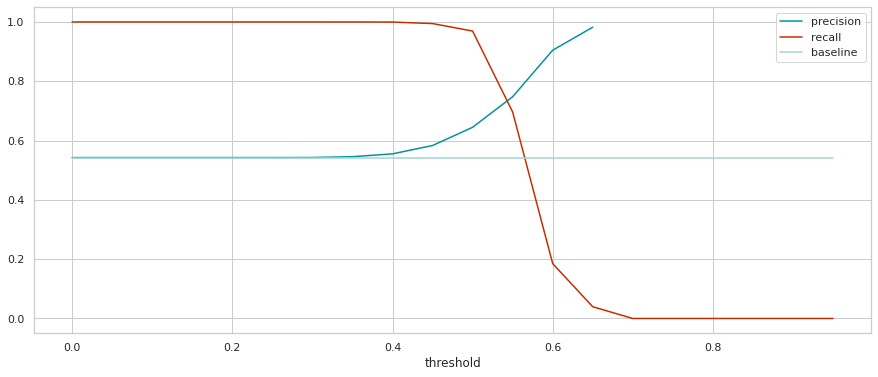

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

contact_preds = preds[:,1]
classify = np.where(preds >= 0.5, 1, 0).flatten()
# baseline performance where we assume all wells are functional
classify.sum()
baseline = target.sum()/len(target)
classify = np.where(contact_preds >= 0.5, 1, 0).flatten()
tn, fp, fn, tp = confusion_matrix(target, classify).ravel()

precision = []
recall = []
ps = []
for p in np.arange(0,1,0.05):
    classify = np.where(contact_preds >= p, 1, 0).flatten()
    tn, fp, fn, tp = confusion_matrix(target, classify).ravel()
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    ps.append(p)

f, ax = plt.subplots(figsize=(15,6))
plt.plot(ps, precision, label='precision');
plt.plot(ps, recall, label='recall');
plt.plot(ps, [baseline]*len(ps), label='baseline');
plt.xlabel("threshold")
plt.legend();
plt.savefig("logit_all_pr.png")

The sweetspot between precision and recall is closer to the baseline performance, making this model less useful for this data set. It might be worth examining other models, feature selection and more hyperparameter tuning in further research.

# 6. Conclusion

The exploratory analysis revealed that the Tanzanian government has great influence on the pumps as they installed the majority of them. They should keep in mind the management and payment schemes, as well as the type of pump installed, since they show significantly different reliabilities. Also, for future planning, the government might reconsider the regional distribution by wealth, climate type and population, to better reach those in need.

The Tanzanian government could achieve a higher chance of picking pumps better when conducting randomized routine checks and could uncover more non-functioning pumps using a machine learning model like logistic regression and could potentially achieve even better results with modified or other models. As of now, accuracy is 26% better than random guessing, so 26% more of the over 22,000 pumps could be found using logit, meaning more than 1 million Tanzanians could receive functioning water pumps again with 180 people in reach of a pump on average.

# 7.  References

1. Water situation in Tanzania:	https://water.org/our-impact/where-we-work/tanzania/
2. Ministry of Water of United Republic of Tanzania:  https://www.maji.go.tz/pages/core-values
3. Predicting the Functional State of Tanzanian Water Pumps https://lib.ugent.be/fulltxt/RUG01/002/350/680/RUG01-002350680_2017_0001_AC.pdf
4. Tanzania water pumps dataset: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/
5. Data used to create the Tanzania GDP dataset: https://www.nbs.go.tz/nbs/takwimu/na/National_Accounts_Statistics_of_Tanzania_Mainland_2018.pdf
6. Data used to create Tanzania Koeppen climate classification dataset: http://earthwise.bgs.ac.uk/index.php/Climate_of_Tanzania
7. Hyperparameter tuning and randomized search for random forests: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74